# Beginner Friendly CATBOOST with OPTUNA
[kaggle link](https://www.kaggle.com/code/kaanboke/beginner-friendly-catboost-with-optuna)

## Heart Failure Prediction Datase

In [ ]:
# DATA DICTONARY

# 1 Age: Age of the patient [years]
# 2 Sex: Sex of the patient [M: Male, F: Female]
# 3 ChestPainType: [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
# 4 RestingBP: Resting blood pressure [mm Hg]
# 5 Cholesterol: Serum cholesterol [mm/dl]
# 6 FastingBS: Fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
# 7 RestingECG: Resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
# 8 MaxHR: Maximum heart rate achieved [Numeric value between 60 and 202]
# 9 ExerciseAngina: Exercise-induced angina [Y: Yes, N: No]
# 10 Oldpeak: ST [Numeric value measured in depression] (
# 11 ST_Slope: The slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
# 12 HeartDisease: Output class [1: heart disease, 0: Normal]

## libraries

In [2]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 20.7 MB/s eta 0:00:00


In [4]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.model_selection import KFold,cross_val_score, RepeatedStratifiedKFold,StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

import optuna
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

from sklearn.model_selection import KFold, cross_val_predict, train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score,classification_report

#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)


import plotly
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import missingno as msno

import warnings
warnings.filterwarnings("ignore")

In [11]:
!pip install kaggle

In [12]:
!kaggle datasets download -d fedesoriano/heart-failure-prediction -p ./heart_dataset --unzip


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [22]:
import pandas as pd

# 최신 Pandas에서 안전하게 적용
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 900)
pd.set_option('display.max_colwidth', 200)

df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [24]:
df.duplicated().sum()

np.int64(0)

In [25]:
def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

missing(df)

,Missing_Number,Missing_Percent
Age,0,0.0
Sex,0,0.0
ChestPainType,0,0.0
RestingBP,0,0.0
Cholesterol,0,0.0
FastingBS,0,0.0
RestingECG,0,0.0
MaxHR,0,0.0
ExerciseAngina,0,0.0
Oldpeak,0,0.0


In [26]:
numerical= df.drop(['HeartDisease'], axis=1).select_dtypes('number').columns

categorical = df.select_dtypes('object').columns

print(f'Numerical Columns:  {df[numerical].columns}')
print('\n')
print(f'Categorical Columns: {df[categorical].columns}')

Numerical Columns:  Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object')


Categorical Columns: Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')


In [27]:
df[categorical].nunique()

,0
Sex,2
ChestPainType,4
RestingECG,3
ExerciseAngina,2
ST_Slope,3


In [28]:
y = df['HeartDisease']
print(f'Percentage of patient had a HeartDisease:  {round(y.value_counts(normalize=True)[1]*100,2)} %  --> ({y.value_counts()[1]} patient)\nPercentage of patient did not have a HeartDisease: {round(y.value_counts(normalize=True)[0]*100,2)}  %  --> ({y.value_counts()[0]} patient)')

Percentage of patient had a HeartDisease:  55.34 %  --> (508 patient)
Percentage of patient did not have a HeartDisease: 44.66  %  --> (410 patient)




*   Almost 55% of the patients had a heart disease.
508 patient had a heart disease.
*   Almost 45% of patients didn't have a heart disease.
410 patient didn't have a heart disease.




*** 기존 코드 오류로 histogram 시각화 불가

In [43]:
# df['HeartDisease'].iplot(kind='hist')  # 기본 색상 지정


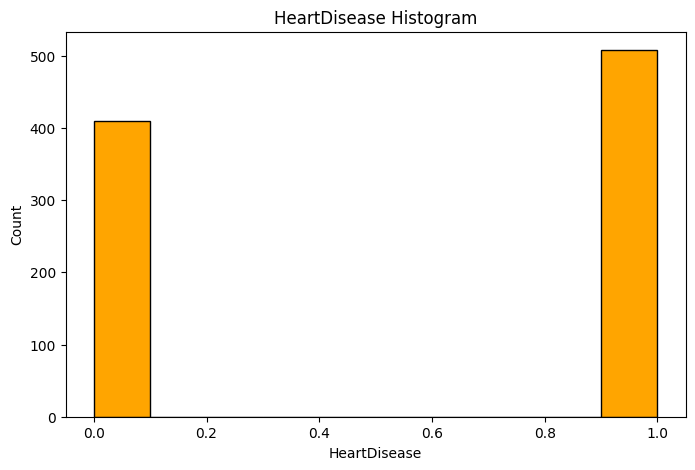

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))        # 그림 크기 설정
plt.hist(df['HeartDisease'],       # 데이터
         bins=10,                  # 구간 개수
         color='orange',           # 막대 색상
         edgecolor='black')        # 막대 테두리 색상
plt.title('HeartDisease Histogram')  # 제목
plt.xlabel('HeartDisease')          # x축 레이블
plt.ylabel('Count')                 # y축 레이블
plt.show()


<Axes: xlabel='HeartDisease', ylabel='count'>

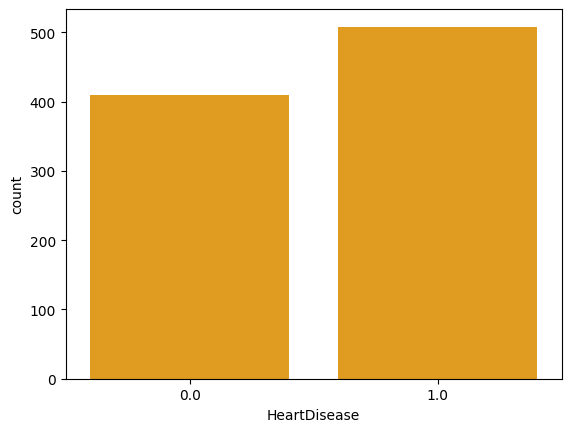

In [50]:
import seaborn as sns
sns.countplot(x='HeartDisease', data=df, color='orange')


## Numerical Features

In [44]:
df[numerical].describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000


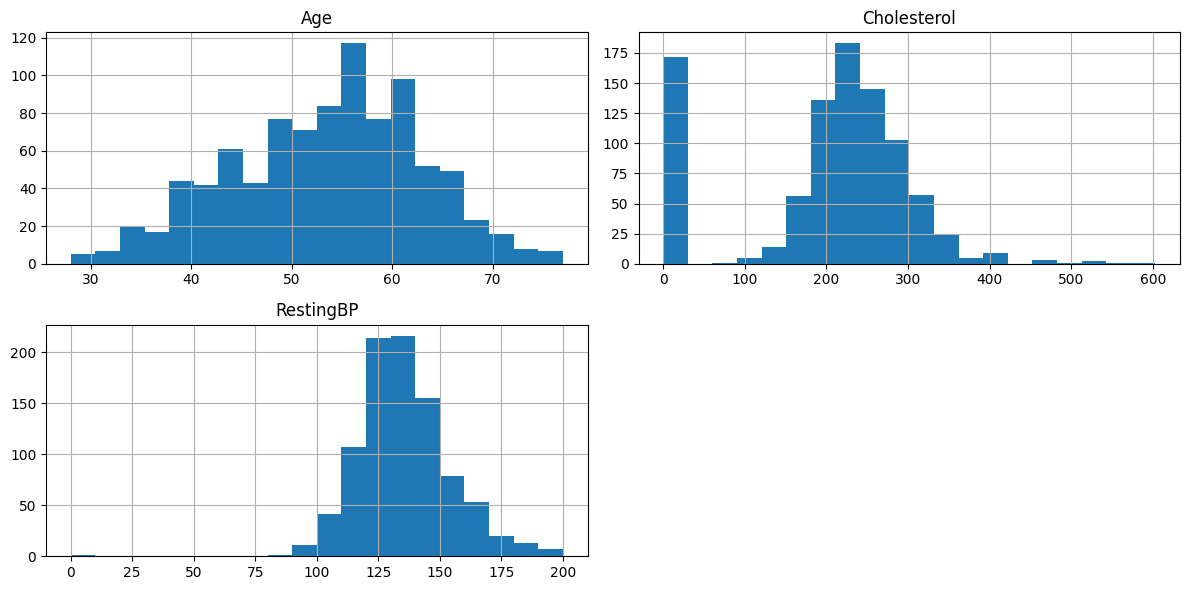

In [46]:
# df[numerical].iplot(kind='hist');

import matplotlib.pyplot as plt

numerical = ['Age', 'Cholesterol', 'RestingBP']  # 예시 컬럼
df[numerical].hist(figsize=(12,6), bins=20)
plt.tight_layout()
plt.show()


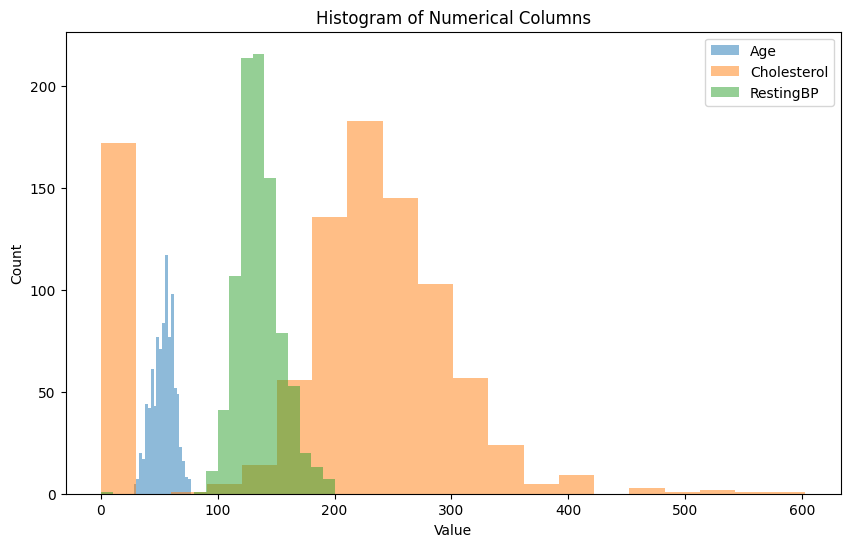

In [52]:
import matplotlib.pyplot as plt

numerical = ['Age', 'Cholesterol', 'RestingBP']
plt.figure(figsize=(10,6))

# 컬럼별로 겹쳐서 히스토그램 그리기
for col in numerical:
    plt.hist(df[col], bins=20, alpha=0.5, label=col)  # alpha=0.5로 반투명 처리

plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Histogram of Numerical Columns')
plt.legend()
plt.show()


In [54]:
# skew_limit = 0.75 # This is our threshold-limit to evaluate skewness. Overall below abs(1) seems acceptable for the linear models.
# skew_vals = df[numerical].drop('FastingBS', axis=1).skew()
# skew_cols= skew_vals[abs(skew_vals)> skew_limit].sort_values(ascending=False)
# skew_cols

In [55]:
skew_limit = 0.75

# drop 전에 컬럼 존재 확인
cols_to_drop = [col for col in ['FastingBS'] if col in df[numerical]]

skew_vals = df[numerical].drop(cols_to_drop, axis=1).skew()
skew_cols = skew_vals[abs(skew_vals) > skew_limit].sort_values(ascending=False)
skew_cols


,0


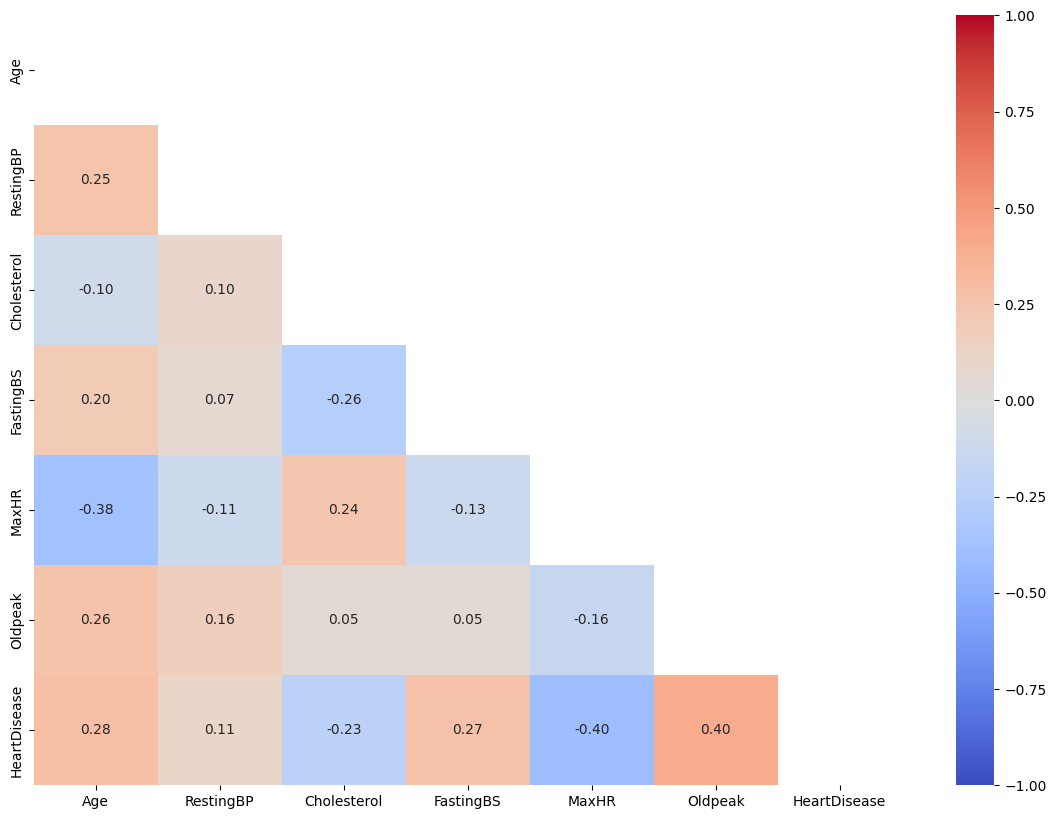

In [56]:
numerical1= df.select_dtypes('number').columns


matrix = np.triu(df[numerical1].corr())
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap (df[numerical1].corr(), annot=True, fmt= '.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm',mask=matrix, ax=ax);

## Categorical Features

In [57]:
df[categorical].head()

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
0,M,ATA,Normal,N,Up
1,F,NAP,Normal,N,Flat
2,M,ATA,ST,N,Up
3,F,ASY,Normal,Y,Flat
4,M,NAP,Normal,N,Up


In [58]:
print (f'A female person has a probability of {round(df[df["Sex"]=="F"]["HeartDisease"].mean()*100,2)} % have a HeartDisease')

print()

print (f'A male person has a probability of {round(df[df["Sex"]=="M"]["HeartDisease"].mean()*100,2)} % have a HeartDisease')

print()

A female person has a probability of 25.91 % have a HeartDisease

A male person has a probability of 63.17 % have a HeartDisease



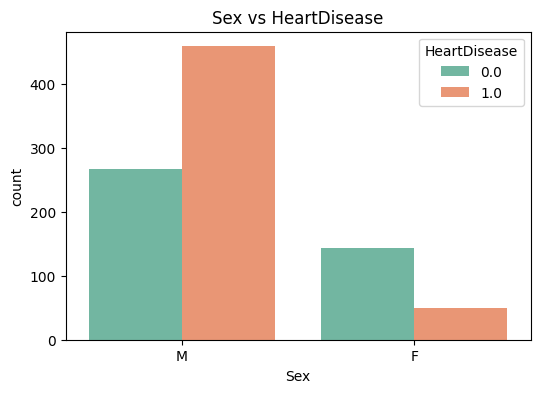

In [61]:
# fig = px.histogram(df, x="Sex", color="HeartDisease",width=400, height=400)
# fig.show()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x='Sex', hue='HeartDisease', data=df, palette='Set2')
plt.title('Sex vs HeartDisease')
plt.show()


문제점
* Men are almost 2.44 times more likely have a heart disease than women.

### Chest Pain Type and Heart Disease

In [60]:
df.groupby('ChestPainType')['HeartDisease'].mean().sort_values(ascending=False)

,HeartDisease
ChestPainType,
ASY,0.790323
TA,0.434783
NAP,0.354680
ATA,0.138728


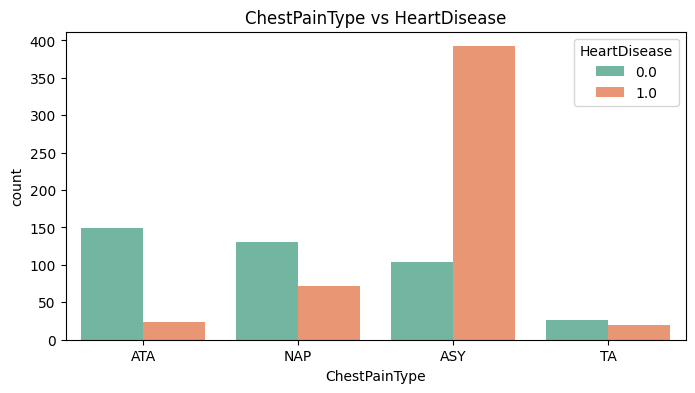

In [65]:
# fig = px.histogram(df, x="ChestPainType", color="HeartDisease",width=400, height=400)
# fig.show()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.countplot(x='ChestPainType', hue='HeartDisease', data=df, palette='Set2')
plt.title('ChestPainType vs HeartDisease')
plt.show()


We can observe clear differences among the chest pain type.
Person with ASY: Asymptomatic chest pain has almost 6 times more likely have a heart disease than person with ATA Atypical Angina chest pain.

### RestingECG and Heart Disease

In [63]:
df.groupby('RestingECG')['HeartDisease'].mean().sort_values(ascending=False)

,HeartDisease
RestingECG,
ST,0.657303
LVH,0.563830
Normal,0.516304


* RestingECG: resting electrocardiogram results don't differ much.
* Person with ST: having ST-T wave abnormality is more likely have a heart disease than the others.

### ExerciseAngina and Heart Disease

In [72]:
# 1. 문자열 → float → int
df['HeartDisease'] = df['HeartDisease'].astype(float).astype(int)

# 2. 그룹별 평균 계산
df.groupby('ExerciseAngina')['HeartDisease'].mean().sort_values(ascending=False)


,HeartDisease
ExerciseAngina,
Y,0.851752
N,0.351005


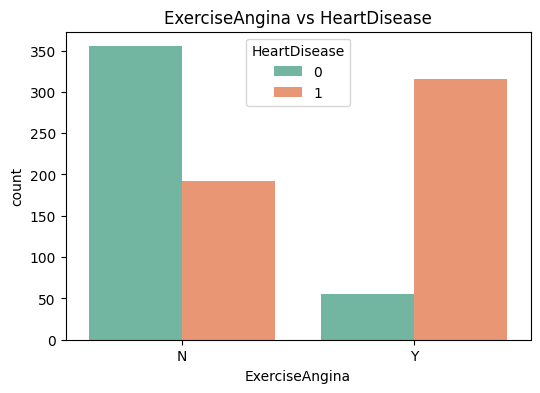

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x='ExerciseAngina', hue='HeartDisease', data=df, palette='Set2')
plt.title('ExerciseAngina vs HeartDisease')
plt.show()


### ST_Slope and Heart Disease

In [75]:
df.groupby('ST_Slope')['HeartDisease'].mean().sort_values(ascending=False)

,HeartDisease
ST_Slope,
Flat,0.828261
Down,0.777778
Up,0.197468


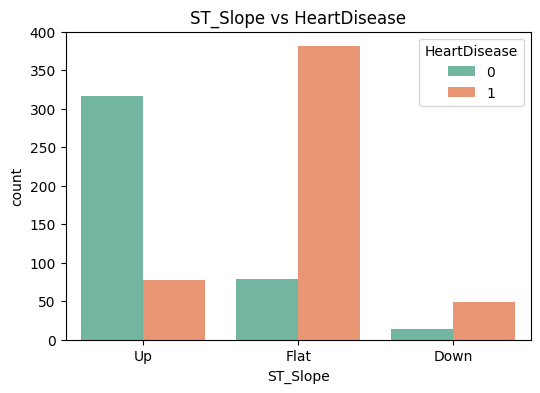

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x='ST_Slope', hue='HeartDisease', data=df, palette='Set2')
plt.title('ST_Slope vs HeartDisease')
plt.show()


* ST_Slope: the slope of the peak exercise ST segment has differences.
* ST_Slope Up significantly less likely has heart disease than the other two segment.

## Overall Insights from the Exploratory Data Analysis

- Target variable has close to balanced data.
- Numerical features have weak correlation with the target variable.
- Oldpeak (depression related number) has a positive correlation with the heart disease.
- Maximum heart rate has negative correlation with the heart disease.
- Interestingly cholesterol has negative correlation with the heart disease.
- Based on the gender; Men are almost 2.44 times more likely have a heart disease than women.
- We can observe clear differences among the chest pain type.
- Person with ASY: Asymptomatic chest pain has almost 6 times more likely have a heart disease than person with ATA Atypical Angina chest pain.
- RestingECG: resting electrocardiogram results don't differ much.
- Person with ST: having ST-T wave abnormality is more likely have a heart disease than the others.
- ExerciseAngina: exercise-induced angina with 'Yes' almost 2.4 times more likley have a heart disaese than exercise-induced angina with 'No'
- ST_Slope: the slope of the peak exercise ST segment has differences.
- ST_Slope Up significantly less likely has heart disease than the other two segment.

## MODEL SELECTION

In [77]:
accuracy =[]
model_names =[]


X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ohe= OneHotEncoder()
ct= make_column_transformer((ohe,categorical),remainder='passthrough')


model = DummyClassifier(strategy='constant', constant=1)
pipe = make_pipeline(ct, model)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred),4))
print (f'model : {model} and  accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

model_names = ['DummyClassifier']
dummy_result_df = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
dummy_result_df

model : DummyClassifier(constant=1, strategy='constant') and  accuracy score is : 0.5942


,Accuracy
DummyClassifier,0.5942


### Logistic & Linear Discriminant & SVC & KNN

In [78]:
accuracy =[]
model_names =[]


X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ohe= OneHotEncoder()
ct= make_column_transformer((ohe,categorical),remainder='passthrough')


lr = LogisticRegression(solver='liblinear')
lda= LinearDiscriminantAnalysis()
svm = SVC(gamma='scale')
knn = KNeighborsClassifier()

models = [lr,lda,svm,knn]

for model in models:
    pipe = make_pipeline(ct, model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred),4))
    print (f'model : {model} and  accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

model_names = ['Logistic','LinearDiscriminant','SVM','KNeighbors']
result_df1 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df1

model : LogisticRegression(solver='liblinear') and  accuracy score is : 0.8841
model : LinearDiscriminantAnalysis() and  accuracy score is : 0.8696
model : SVC() and  accuracy score is : 0.7246
model : KNeighborsClassifier() and  accuracy score is : 0.7174


,Accuracy
Logistic,0.8841
LinearDiscriminant,0.8696
SVM,0.7246
KNeighbors,0.7174


### Logistic & Linear Discriminant & SVC & KNN with Scaler

In [79]:
accuracy =[]
model_names =[]


X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ohe= OneHotEncoder()
s= StandardScaler()
ct1= make_column_transformer((ohe,categorical),(s,numerical))


lr = LogisticRegression(solver='liblinear')
lda= LinearDiscriminantAnalysis()
svm = SVC(gamma='scale')
knn = KNeighborsClassifier()

models = [lr,lda,svm,knn]

for model in models:
    pipe = make_pipeline(ct1, model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred),4))
    print (f'model : {model} and  accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

model_names = ['Logistic_scl','LinearDiscriminant_scl','SVM_scl','KNeighbors_scl']
result_df2 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df2

model : LogisticRegression(solver='liblinear') and  accuracy score is : 0.8551
model : LinearDiscriminantAnalysis() and  accuracy score is : 0.8587
model : SVC() and  accuracy score is : 0.8804
model : KNeighborsClassifier() and  accuracy score is : 0.8696


,Accuracy
Logistic_scl,0.8551
LinearDiscriminant_scl,0.8587
SVM_scl,0.8804
KNeighbors_scl,0.8696


- As expected, with scaler, both KNN and SVM did a better job with the scaler than their previous performances.
스케일러가 있는 경우 더 나음
- Let's see how ensemble models do with the problem at hand.

### Ensemble Models (AdaBoost & Gradient Boosting & Random Forest & Extra Trees)

In [80]:
accuracy =[]
model_names =[]


X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ohe= OneHotEncoder()
ct= make_column_transformer((ohe,categorical),remainder='passthrough')

ada = AdaBoostClassifier(random_state=0)
gb = GradientBoostingClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0)
et=  ExtraTreesClassifier(random_state=0)



models = [ada,gb,rf,et]

for model in models:
    pipe = make_pipeline(ct, model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred),4))
    print (f'model : {model} and  accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

model_names = ['Ada','Gradient','Random','ExtraTree']
result_df3 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df3

model : AdaBoostClassifier(random_state=0) and  accuracy score is : 0.8732
model : GradientBoostingClassifier(random_state=0) and  accuracy score is : 0.8768
model : RandomForestClassifier(random_state=0) and  accuracy score is : 0.8877
model : ExtraTreesClassifier(random_state=0) and  accuracy score is : 0.8804


,Accuracy
Ada,0.8732
Gradient,0.8768
Random,0.8877
ExtraTree,0.8804


### Famous Trio (XGBoost & LightGBM & Catboost)

In [81]:
accuracy =[]
model_names =[]


X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ohe= OneHotEncoder()
ct= make_column_transformer((ohe,categorical),remainder='passthrough')

xgbc = XGBClassifier(random_state=0)
lgbmc=LGBMClassifier(random_state=0)


models = [xgbc,lgbmc]

for model in models:
    pipe = make_pipeline(ct, model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred),4))

model_names = ['XGBoost','LightGBM']
result_df4 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df4

[LightGBM] [Info] Number of positive: 344, number of negative: 298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 354
[LightGBM] [Info] Number of data points in the train set: 642, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.535826 -> initscore=0.143548
[LightGBM] [Info] Start training from score 0.143548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

,Accuracy
XGBoost,0.8478
LightGBM,0.8732


### CATBOOST

In [83]:
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

accuracy = []
model_names = []

X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# np.float → float 로 변경
categorical_features_indices = np.where(X.dtypes != float)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = CatBoostClassifier(verbose=False, random_state=0)

model.fit(X_train, y_train, cat_features=categorical_features_indices, eval_set=(X_test, y_test))
y_pred = model.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred), 4))

model_names = ['Catboost_default']
result_df5 = pd.DataFrame({'Accuracy': accuracy}, index=model_names)
result_df5


,Accuracy
Catboost_default,0.8804


### Catboost HyperParameter Tuning with Optuna

In [85]:
def objective(trial):
    X = df.drop('HeartDisease', axis=1)
    y = df['HeartDisease']

    # np.float → float로 변경
    categorical_features_indices = np.where(X.dtypes != float)[0]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cat_cls = CatBoostClassifier(**param)

    cat_cls.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        cat_features=categorical_features_indices,
        verbose=0,
        early_stopping_rounds=100
    )

    preds = cat_cls.predict(X_test)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_test, pred_labels)
    return accuracy

if __name__ == "__main__":
    import optuna
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


[I 2025-10-06 13:58:58,242] A new study created in memory with name: no-name-97e3d77e-efa3-4ee3-b84c-a22c2063aed2
[I 2025-10-06 13:59:04,046] Trial 0 finished with value: 0.8804347826086957 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.08174313055663, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.265386943033498}. Best is trial 0 with value: 0.8804347826086957.
[I 2025-10-06 13:59:09,570] Trial 1 finished with value: 0.8695652173913043 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.057397372747317515, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.050589747865321}. Best is trial 0 with value: 0.8804347826086957.
[I 2025-10-06 13:59:19,559] Trial 2 finished with value: 0.8731884057971014 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.07465165781906416, 'depth': 11, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_tempe

Number of finished trials: 50
Best trial:
  Value: 0.8985507246376812
  Params: 
    objective: Logloss
    colsample_bylevel: 0.03192088663498133
    depth: 5
    boosting_type: Ordered
    bootstrap_type: MVS


Parameters:

- Objective: Supported metrics for overfitting detection and best model selection

- colsample_bylevel: this parameter speeds up the training and usually does not affect the quality.

- depht : Depth of the tree.

- boosting_type : By default, the boosting type is set to for small datasets. This prevents overfitting but it is expensive in terms of computation. Try to set the value of this parameter to to speed up the training.

- bootstrap_type : By default, the method for sampling the weights of objects is set to . The training is performed faster if the method is set and the value for the sample rate for bagging is smaller than 1.

### new parameters

In [87]:

accuracy = []
model_names = []

X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# np.float → float
categorical_features_indices = np.where(X.dtypes != float)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = CatBoostClassifier(
    verbose=False,
    random_state=0,
    objective='CrossEntropy',
    colsample_bylevel=0.04292240490294766,
    depth=10,
    boosting_type='Plain',
    bootstrap_type='MVS'
)

model.fit(X_train, y_train, cat_features=categorical_features_indices, eval_set=(X_test, y_test))
y_pred = model.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred), 4))
print(classification_report(y_test, y_pred))

model_names = ['Catboost_tuned']
result_df6 = pd.DataFrame({'Accuracy': accuracy}, index=model_names)
result_df6


              precision    recall  f1-score   support

           0       0.88      0.90      0.89       112
           1       0.93      0.91      0.92       164

    accuracy                           0.91       276
   macro avg       0.90      0.91      0.91       276
weighted avg       0.91      0.91      0.91       276



,Accuracy
Catboost_tuned,0.9094


## Feature Importance

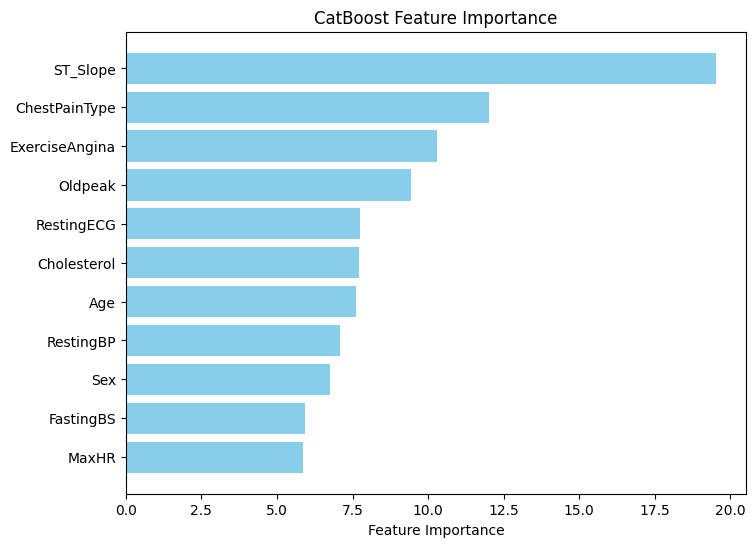

In [91]:
# feature_importance = np.array(model.get_feature_importance())
# features = np.array(X_train.columns)
# fi={'features':features,'feature_importance':feature_importance}
# df_fi = pd.DataFrame(fi)
# df_fi.sort_values(by=['feature_importance'], ascending=True,inplace=True)
# fig = px.bar(df_fi, x='feature_importance', y='features',title="CatBoost Feature Importance",height=500)
# fig.show()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

feature_importance = np.array(model.get_feature_importance())
features = np.array(X_train.columns)

df_fi = pd.DataFrame({
    'features': features,
    'feature_importance': feature_importance
})

df_fi.sort_values(by='feature_importance', ascending=True, inplace=True)

plt.figure(figsize=(8,6))
plt.barh(df_fi['features'], df_fi['feature_importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance')
plt.show()


## Model Comparison


In [92]:
result_final = pd.concat([dummy_result_df,result_df1,result_df2,result_df3,result_df4,result_df5,result_df6],axis=0)

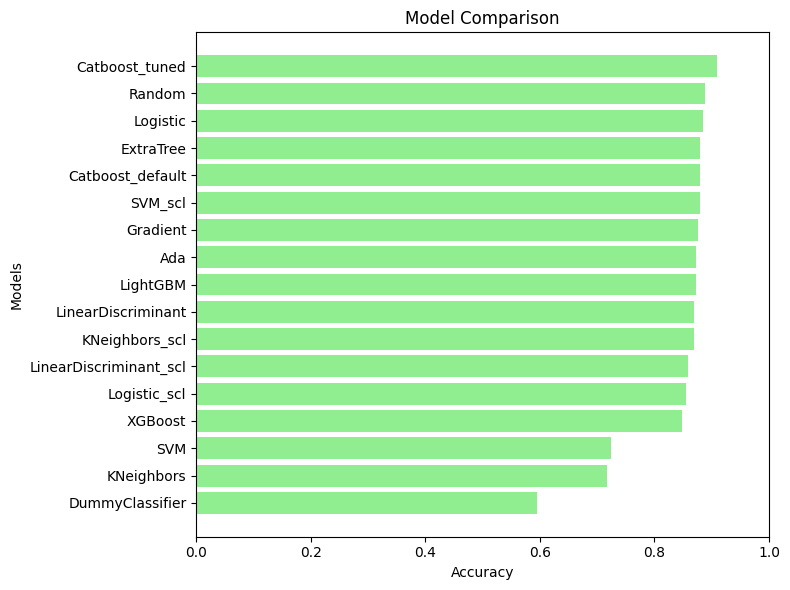

In [94]:
import matplotlib.pyplot as plt

# result_final은 이전에 만들어진 DataFrame
# 예: result_final = pd.DataFrame({'Accuracy':[0.85,0.90]}, index=['Model1','Model2'])

# Accuracy 기준 오름차순 정렬
result_final.sort_values(by='Accuracy', ascending=True, inplace=True)

plt.figure(figsize=(8,6))
plt.barh(result_final.index, result_final['Accuracy'], color='lightgreen')
plt.xlabel('Accuracy')
plt.ylabel('Models')
plt.title('Model Comparison')
plt.xlim(0, 1)  # Accuracy가 0~1 사이이므로
plt.tight_layout()
plt.show()


## Conclusion 결론

우리는 심장병 사례를 분류하는 모델을 개발했습니다.

먼저, **상세한 탐색적 데이터 분석(EDA)**을 수행했습니다.

어떤 **평가 지표(metric)**를 사용할지 결정했습니다.

**타깃과 피처(feature)**를 모두 상세히 분석했습니다.

모델에 사용할 수 있도록 범주형 변수를 수치형으로 변환했습니다.

데이터 누수(data leakage)를 방지하기 위해 파이프라인(pipeline)을 사용했습니다.

각 모델의 결과를 확인하고, 문제에 가장 적합한 모델을 선택했습니다.

특히 CatBoost 모델을 상세히 분석했습니다.

Optuna를 활용한 CatBoost 하이퍼파라미터 튜닝을 통해 성능 향상을 확인했습니다.

**피처 중요도(feature importance)**를 확인했습니다.

이후 단계는 사용자가 모델을 개발 및 개선할 차례입니다


We have developed model to classifiy heart disease cases. First, we made the detailed exploratory analysis. We have decided which metric to use. We analyzed both target and features in detail. We transform categorical variables into numeric so we can use them in the model. We use pipeline to avoid data leakage. We looked at the results of the each model and selected the best one for the problem on hand. We looked in detail Catboost We made hyperparameter tuning of the Catboost with Optuna to see the improvement We looked at the feature importance. After this point it is up to you to develop and improve the models.